### KITTI Dataset 다운로드
* 작은 용량의 KITTI Dataset을 다운로드하고 /content 밑에 압축 해제

In [ ]:
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

In [ ]:
import matplotlib.pyplot as plt
import cv2

img = cv2.cvtColor(cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 10))
plt.imshow(img)

### KITTI DATA FORMAT 확인
* 첫번째 컬럼은 해당 오브젝트의 클래스 명.
* 5번째~8번째가 BOUNDING BOX 정보임. 좌상단(xmin, ymin), 우하단(xmax, ymax) 좌표 임.

In [ ]:
!cat /content/kitti_tiny/training/label_2/000068.txt

### KITTI annotation 파일들의 리스트들을 가지는 파일 확인.

In [ ]:
!cat /content/kitti_tiny/train.txt

### mmdetection의 중립 annotation 포맷 변환. 해당 포맷은 텍스트로 변환하지 않음. 바로 메모리 상의 list로 생성됨.  
#### filename, width, height, ann을 Key로 가지는 Dictionary를 이미지 개수대로 가지는 list 생성.
* filename: 이미지 파일명(디렉토리는 포함하지 않음)
* width: 이미지 너비
* height: 이미지 높이
* ann: bbounding box와 label에 대한 정보를 가지는 Dictionary
 - bboxes: 하나의 이미지에 있는 여러 Object 들의 numpy array. 4개의 좌표값(좌상단, 우하단)을 가지고, 해당 이미지에 n개의 Object들이 있을 경우 array의 shape는 (n, 4)
 - labels: 하나의 이미지에 있는 여러 Object들의 numpy array. shape는 (n, )
 - bboxes_ignore: 학습에 사용되지 않고 무시하는 bboxes. 무시하는 bboxes의 개수가 k개이면 shape는 (k, 4)
 - labels_ignore: 학습에 사용되지 않고 무시하는 labels. 무시하는 bboxes의 개수가 k개이면 shape는 (k,)



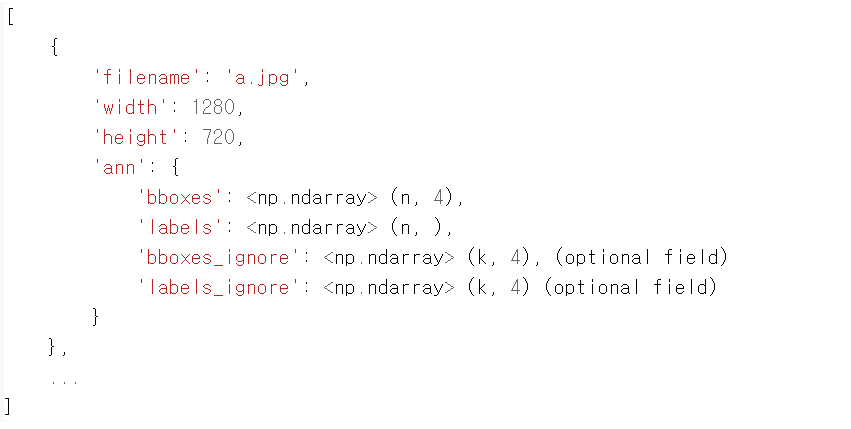

### kitti Dataset을 중립 데이터형태로 변환하여 메모리 로드

In [ ]:
# 원본 kitti Dataset는 10개의 Class로 되어 있음. 'Car Van Truck Pedestrian Person_sitting Cyclist Tram Misc DontCare'
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
cat2label = {k:i for i, k in enumerate(CLASSES)}
print(cat2label)
cat2label['Car']


In [ ]:
image_list = mmcv.list_from_file('/content/kitti_tiny/train.txt')


In [ ]:
lines = mmcv.list_from_file('/content/kitti_tiny/training/label_2/000064.txt')
#print(lines)
content = [line.strip().split(' ') for line in lines]
bbox_names = [x[0] for x in content]
#print(bbox_names)
bboxes = [ [float(info) for info in x[4:8]] for x in content]
print(bboxes)

In [ ]:
import copy
import os.path as osp
import cv2

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

# 반드시 아래 Decorator 설정 할것.@DATASETS.register_module() 설정 시 force=True를 입력하지 않으면 Dataset 재등록 불가.
@DATASETS.register_module(force=True)
class KittyTinyDataset(CustomDataset):
  CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')

  ##### self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/train.txt self.img_prefix: /content/kitti_tiny/training/image_2
  #### ann_file: /content/kitti_tiny/train.txt
  # annotation에 대한 모든 파일명을 가지고 있는 텍스트 파일을 __init__(self, ann_file)로 입력 받고, 이 self.ann_file이 load_annotations()의 인자로 입력
  def load_annotations(self, ann_file):
    print('##### self.data_root:', self.data_root, 'self.ann_file:', self.ann_file, 'self.img_prefix:', self.img_prefix)
    print('#### ann_file:', ann_file)
    cat2label = {k:i for i, k in enumerate(self.CLASSES)}
    image_list = mmcv.list_from_file(self.ann_file)
    # 포맷 중립 데이터를 담을 list 객체
    data_infos = []

    for image_id in image_list:
      filename = '{0:}/{1:}.jpeg'.format(self.img_prefix, image_id)
      # 원본 이미지의 너비, 높이를 image를 직접 로드하여 구함.
      image = cv2.imread(filename)
      height, width = image.shape[:2]
      # 개별 image의 annotation 정보 저장용 Dict 생성. key값 filename 에는 image의 파일명만 들어감(디렉토리는 제외)
      data_info = {'filename': str(image_id) + '.jpeg',
                   'width': width, 'height': height}
      # 개별 annotation이 있는 서브 디렉토리의 prefix 변환.
      label_prefix = self.img_prefix.replace('image_2', 'label_2')
      # 개별 annotation 파일을 1개 line 씩 읽어서 list 로드
      lines = mmcv.list_from_file(osp.join(label_prefix, str(image_id)+'.txt'))

      # 전체 lines를 개별 line별 공백 레벨로 parsing 하여 다시 list로 저장. content는 list의 list형태임.
      # ann 정보는 numpy array로 저장되나 텍스트 처리나 데이터 가공이 list 가 편하므로 일차적으로 list로 변환 수행.
      content = [line.strip().split(' ') for line in lines]
      # 오브젝트의 클래스명은 bbox_names로 저장.
      bbox_names = [x[0] for x in content]
      # bbox 좌표를 저장
      bboxes = [ [float(info) for info in x[4:8]] for x in content]

      # 클래스명이 해당 사항이 없는 대상 Filtering out, 'DontCare'sms ignore로 별도 저장.
      gt_bboxes = []
      gt_labels = []
      gt_bboxes_ignore = []
      gt_labels_ignore = []

      for bbox_name, bbox in zip(bbox_names, bboxes):
        # 만약 bbox_name이 클래스명에 해당 되면, gt_bboxes와 gt_labels에 추가, 그렇지 않으면 gt_bboxes_ignore, gt_labels_ignore에 추가
        if bbox_name in cat2label:
          gt_bboxes.append(bbox)
          # gt_labels에는 class id를 입력
          gt_labels.append(cat2label[bbox_name])

        else:
          gt_bboxes_ignore.append(bbox)
          gt_labels_ignore.append(-1)
      # 개별 image별 annotation 정보를 가지는 Dict 생성. 해당 Dict의 value값은 모두 np.array임.
      data_anno = {
          'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
          'labels': np.array(gt_labels, dtype=np.long),
          'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
          'labels_ignore': np.array(gt_labels_ignore, dtype=np.long)
      }
      # image에 대한 메타 정보를 가지는 data_info Dict에 'ann' key값으로 data_anno를 value로 저장.
      data_info.update(ann=data_anno)
      # 전체 annotation 파일들에 대한 정보를 가지는 data_infos에 data_info Dict를 추가
      data_infos.append(data_info)

    return data_infos


In [ ]:
### Config 설정하고 Pretrained 모델 다운로드
config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [ ]:
!cd mmdetection; mkdir checkpoints
!wget -O /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

In [ ]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

In [ ]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정.
cfg.dataset_type = 'KittyTinyDataset'
cfg.data_root = '/content/kitti_tiny/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정.
cfg.data.train.type = 'KittyTinyDataset'
cfg.data.train.data_root = '/content/kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittyTinyDataset'
cfg.data.val.data_root = '/content/kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

cfg.data.test.type = 'KittyTinyDataset'
cfg.data.test.data_root = '/content/kitti_tiny/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'training/image_2'

# class의 갯수 수정.
cfg.model.roi_head.bbox_head.num_classes = 4
# pretrained 모델
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정.
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정.
cfg.optimizer.lr = 0.02 / 8

cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# config 수행 시마다 policy값이 없어지는 bug로 인하여 설정.
cfg.lr_config.policy = 'step'

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# ConfigDict' object has no attribute 'device 오류 발생시 반드시 설정 필요. https://github.com/open-mmlab/mmdetection/issues/7901
cfg.device='cuda'


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

### Config에서 설정한 Dataset과 Model, 동적 학습율, Pipeline 설정에 따라 모델 학습 수행.

* train용 Dataset을 생성하고 이를 이용하여 학습 수행.

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성.
datasets = [build_dataset(cfg.data.train)]

In [ ]:
datasets

In [ ]:
datasets[0].CLASSES

In [ ]:
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

In [ ]:
# 주의, config에 pretrained 모델 지정이 상대 경로로 설정됨 cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
# 아래와 같이 %cd mmdetection 지정 필요.

%cd mmdetection

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# epochs는 config의 runner 파라미터로 지정됨. 기본 12회
train_detector(model, datasets, cfg, distributed=False, validate=True)

### 학습된 model을 이용하여 inference 수행.

In [ ]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# BGR Image 사용
img = cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result)

### 학습된 모델을 이용하여 Video Detection 수행하기

In [ ]:
%cd /content
!mkdir /content/data
!wget -O /content/data/the_rock_chase.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/the_rock_chase.mp4?raw=true

In [ ]:
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
labels_to_names_seq = {i:k for i, k in enumerate(CLASSES)}
labels_to_names_seq

In [ ]:
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
cat2label = {k:i for i, k in enumerate(CLASSES)}

def get_detected_img(model, img_array,  score_threshold=0.3, is_print=True):
  # 인자로 들어온 image_array를 복사.
  draw_img = img_array.copy()
  bbox_color=(0, 255, 0)
  text_color=(0, 0, 255)

  # model과 image array를 입력 인자로 inference detection 수행하고 결과를 results로 받음.
  # results는 80개의 2차원 array(shape=(오브젝트갯수, 5))를 가지는 list.
  results = inference_detector(model, img_array)

  # 80개의 array원소를 가지는 results 리스트를 loop를 돌면서 개별 2차원 array들을 추출하고 이를 기반으로 이미지 시각화
  # results 리스트의 위치 index가 바로 COCO 매핑된 Class id. 여기서는 result_ind가 class id
  # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐.
  for result_ind, result in enumerate(results):
    # 개별 2차원 array의 row size가 0 이면 해당 Class id로 값이 없으므로 다음 loop로 진행.
    if len(result) == 0:
      continue

    # 2차원 array에서 5번째 컬럼에 해당하는 값이 score threshold이며 이 값이 함수 인자로 들어온 score_threshold 보다 낮은 경우는 제외.
    result_filtered = result[np.where(result[:, 4] > score_threshold)]

    # 해당 클래스 별로 Detect된 여러개의 오브젝트 정보가 2차원 array에 담겨 있으며, 이 2차원 array를 row수만큼 iteration해서 개별 오브젝트의 좌표값 추출.
    for i in range(len(result_filtered)):
      # 좌상단, 우하단 좌표 추출.
      left = int(result_filtered[i, 0])
      top = int(result_filtered[i, 1])
      right = int(result_filtered[i, 2])
      bottom = int(result_filtered[i, 3])
      caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], result_filtered[i, 4])
      cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
      cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)
      if is_print:
        print(caption)

  return draw_img

In [ ]:
import time

def do_detected_video(model, input_path, output_path, score_threshold, do_print=True):

    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)
    btime = time.time()
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        stime = time.time()
        img_frame = get_detected_img(model, img_frame,  score_threshold=score_threshold, is_print=False)
        if do_print:
          print('frame별 detection 수행 시간:', round(time.time() - stime, 4))
        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

    print('최종 detection 완료 수행 시간:', round(time.time() - btime, 4))

In [ ]:
do_detected_video(model, '/content/data/the_rock_chase.mp4', '/content/data/the_rock_chase_out1.mp4', score_threshold=0.4, do_print=True)